In [3]:
import pandas as pd
import numpy as np
import joblib,json,os,time
import benchmark_common as bcommon
import config as cfg
import benchmark_test as btest
import benchmark_train as btrain
import benchmark_evaluation as eva
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tools.funclib as funclib
import tools.embedding_esm as esmebd

import benchmark_evaluation as eva
from tqdm.notebook import tqdm
from pandarallel import pandarallel #  import pandaralle
pandarallel.initialize() 
from sklearn import metrics,preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Input, Dense, GRU, Bidirectional
from tools.Attention import Attention

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 52 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用'/gpu:0'
def prepare_task_input(data_train, data_test, feature_df, task_name='task2'):
    num_features= feature_df.shape[1] - 1

    data_train = data_train.merge(feature_df, on='id', how='left')
    data_test = data_test.merge(feature_df, on='id', how='left')

    train_X =  data_train.iloc[:, np.r_[3:(3+num_features)]]
    test_X =  data_test.iloc[:, np.r_[3:(3+num_features)]]

    label_encoder = preprocessing.LabelEncoder()

    if task_name == 'task1':
        labels = pd.concat([data_train.isenzyme, data_train.isenzyme], axis=0)
        label_encoder.fit(labels)

        train_Y = np_utils.to_categorical(label_encoder.transform(data_train.isenzyme)).astype('int')
        test_Y = np_utils.to_categorical(label_encoder.transform(data_test.isenzyme)).astype('int')

    if task_name == 'task2':
        labels = pd.concat([data_train.functionCounts, data_train.functionCounts], axis=0)
        label_encoder.fit(labels)
        train_Y = np_utils.to_categorical(label_encoder.transform(data_train.functionCounts)).astype('int')
        test_Y = np_utils.to_categorical(label_encoder.transform(data_test.functionCounts)).astype('int')
    

    train_X = np.array(train_X).reshape((-1, 1, num_features))
    test_X = np.array(test_X).reshape((-1, 1, num_features))
    return train_X, train_Y, test_X, test_Y, label_encoder


def get_model(num_features, num_class):
    keras.backend.clear_session()
    inputs = Input(shape=(1, num_features, ), name="input")
    gru = Bidirectional(GRU(128, dropout=0.2, return_sequences=True), name="bi-gru")(inputs)
    attention = Attention(32, name="attention")(gru) 
    # attention = keras.layers.MultiHeadAttention(num_heads=2, key_dim=(2,3), value_dim=32)(gru)   
    dense = Dense(64, activation='relu', name="dense1")(attention)
    output = Dense(num_class, activation='sigmoid', name="lniear")(dense)

    model = Model(inputs, output)
    model.summary()
    return model

def model_train(model,train_X, train_Y, test_X, test_Y, lr=0.001, epochs=20, task_name='task1'):
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

    if task_name == 'task1':
        tid = 1
    if task_name == 'task2':
        tid = 2
    if task_name == 'task3':
        tid = 3

    checkpoint = keras.callbacks.ModelCheckpoint(filepath=f'{cfg.MODELDIR}/m_task{tid}.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')

    history = model.fit(
                            x=train_X, 
                            y=train_Y, 
                            validation_data=(test_X, test_Y),
                            batch_size=2048, 
                            epochs=epochs,
                            steps_per_epoch=10,
                            callbacks=[checkpoint]
                        )
    return model, history

def draw_loss_func(history):
    plt.subplot(2, 1, 1)
    epochs = len(history.history['loss'])
    plt.plot(range(epochs), history.history['loss'], label='loss')
    plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
    plt.legend()

    plt.subplot(2, 1, 2)

    epochs = len(history.history['accuracy'])
    plt.plot(range(epochs), history.history['accuracy'], label='acc')
    plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.savefig("loss_acc.png")

def model_predict(load_model, test_X, test_Y, task_name='task1'):
    # load_model = keras.models.load_model(f'{cfg.MODELDIR}/m_task1.h5', custom_objects={"Attention": Attention}, compile=False)
    predicted = load_model.predict(test_X)
    task_res=pd.DataFrame({'ground_truth':np.argmax(test_Y, axis=1), 'predicted':np.argmax(predicted, axis=1)})

    if task_name == 'task1':
        print('baslineName', '\t', 'accuracy','\t', 'precision(PPV) \t NPV \t\t', 'recall','\t', 'f1', '\t\t', '\t confusion Matrix')
        eva.caculateMetrix(groundtruth=task_res.ground_truth, predict=task_res.predicted, baselineName='GRU', type='binary')
    if task_name == 'task2':
        print('%12s'%'baslineName', '\t\t', 'accuracy','\t', 'precision-macro \t', 'recall-macro','\t', 'f1-macro')
        eva.caculateMetrix(groundtruth=task_res.ground_truth, predict=task_res.predicted, baselineName='GRU', type='multi')

    return task_res

In [12]:
from tqdm import tqdm
cc = 0
for i in tqdm(range(10000), position=0):
    cc = cc+1

100%|██████████| 10000/10000 [00:00<00:00, 3704561.03it/s]


In [3]:
print('------------Task1------------------')
EMBEDDING_METHOD = 'esm32'
NUM_FEATURE = 1280
print('step 1: loading task data')
data_task1_train = pd.read_feather(cfg.FILE_TASK1_TRAIN)
data_task1_test = pd.read_feather(cfg.FILE_TASK1_TEST)
print(f'step 2: Loading features, embdding method={EMBEDDING_METHOD}')
feature_df = bcommon.load_data_embedding(embedding_type=EMBEDDING_METHOD)
print('step 3: Prepare model data')
task1_train_X, task1_train_Y, task1_test_X, task1_test_Y, task1_label_encoder = prepare_task_input(data_train=data_task1_train, data_test=data_task1_test, feature_df=feature_df, task_name='task1')

------------Task1------------------
step 1: loading task data
step 2: Loading features, embdding method=esm32
step 3: Prepare model data


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1, 1280)]         0         
                                                                 
 bi-gru (Bidirectional)      (None, 1, 256)            1082880   
                                                                 
 attention (Attention)       (None, 256)               8225      
                                                                 
 dense1 (Dense)              (None, 64)                16448     
                                                                 
 lniear (Dense)              (None, 2)                 130       
                                                                 
Total params: 1,107,683
Trainable params: 1,107,683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
10/10 [==============================] -

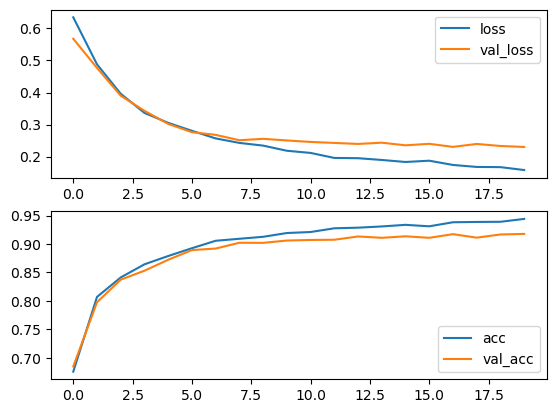

In [4]:
model=get_model(num_features=task1_test_X.shape[2], num_class=task1_test_Y.shape[1])
t1_m,t1_history= model_train(   model=model,
                                train_X=task1_train_X, train_Y=task1_train_Y,
                                test_X =task1_test_X,  test_Y =task1_test_Y, 
                                lr=0.0005, epochs=20, 
                                task_name='task1'
                            )
draw_loss_func(history=t1_history)

task1_res = model_predict(load_model=t1_m, test_X=task1_test_X, test_Y=task1_test_Y, task_name='task1')

In [3]:
print('------------Task2------------------')
EMBEDDING_METHOD = 'esm32'
NUM_FEATURE = 1280
data_task2_train = pd.read_feather(cfg.FILE_TASK2_TRAIN)
data_task2_test = pd.read_feather(cfg.FILE_TASK2_TEST)
print(f'step 2: Loading features, embdding method={EMBEDDING_METHOD}')
feature_df = bcommon.load_data_embedding(embedding_type=EMBEDDING_METHOD)
print('step 3: Prepare model data')
task2_train_X, task2_train_Y, task2_test_X, task2_test_Y, task2_label_encoder = prepare_task_input(data_train=data_task2_train, data_test=data_task2_test, feature_df=feature_df, task_name='task2')

------------Task2------------------
step 2: Loading features, embdding method=esm32
step 3: Prepare model data


In [ ]:
model=get_model(num_features=task2_test_X.shape[2], num_class=task2_test_Y.shape[1])
t2_m,t2_history= model_train(   model=model,
                                train_X=task2_train_X, train_Y=task2_train_Y,
                                test_X =task2_test_X,  test_Y =task2_test_Y, 
                                lr=0.0001, epochs=10000, 
                                task_name='task2'
                            )
draw_loss_func(history=t2_history)

task2_res = model_predict(load_model=t2_m, test_X=task2_test_X, test_Y=task2_test_Y, task_name='task2')

In [7]:
data_task2_train_cluster = bcommon.pycdhit(uniportid_seq_df=data_task2_train, identity=0.4, thred_num=104)

Write finished


In [36]:
data_task2_test

,id,seq,functionCounts
0,P9WG69,MTTSVIVAGARTPIGKLMGSLKDFSASELGAIAIKGALEKANVPAS...,1
1,P9WI52,MAERAPRGEVAVMVAVQSALVDRPGMLATARGLSHFGEHCIGWLIL...,1
2,P9WQ38,MRALHVPAGSATALLLPALQRVLGGSDPALVAVPTQHESLLGALRV...,1
3,P9WIA9,DAGVSWKVYRNKTLGPISSVLTYGSLVTSFKQSADPRSDLVRFGVA...,1
4,D8GR70,MASYLTLFISAVVVNNYVLTRFLGLCIFFGVSKNLNASVGMGMAVT...,1
...,...,...,...
5106,A2WLP4,MVSAAAGWAAPAFAVAAVVIWVVLCGELLRRRRRGAGSGKGDAAAA...,1
5107,A0A250YGJ5,MSVNYAAGLSPYADKGKCGLPEIFDPPEELERKVWELARLVRQSSN...,2
5108,A0A2K5TU92,MSVNYAAGLSPYADKGKCGLPEIFDPPEELERKVWELARLVWQSSH...,2
5109,A0A3R0A696,MKHWKKMAASLIAISTMVAVVPTTYAMESEDSQPQTTDTATVQTTK...,1


In [14]:
un_thres = data_task2_train_cluster[(~data_task2_train_cluster.uniprot_id.isin(data_task2_train[data_task2_train.functionCounts!=1].id)) &(data_task2_train_cluster.is_representative)]
un_thres

,cluster_id,uniprot_id,identity,is_representative,cluster_size
216,0,Q8EWY8,1.0,True,835
924,1,Q9PR12,1.0,True,694
1539,2,P15007,1.0,True,681
2872,4,P07264,1.0,True,629
4067,5,B2JX50,1.0,True,607
...,...,...,...,...,...
222469,27921,P34946,1.0,True,1
222470,27922,Q58885,1.0,True,1
222471,27923,Q7VGR5,1.0,True,1
222472,27924,Q9CJH4,1.0,True,1


In [14]:
task2_res = model_predict(load_model=t2_m, test_X=task2_test_X, test_Y=task2_test_Y, task_name='task2')

task2_res.ground_truth = task2_res.ground_truth +1
task2_res.predicted = task2_res.predicted +1
task2_res

160/160 [==============================] - 0s 1ms/step
 baslineName 		 accuracy 	 precision-macro 	 recall-macro 	 f1-macro
         GRU  		0.924085  	0.700306 		0.278932 	0.329744


,ground_truth,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
5106,1,1
5107,2,1
5108,2,1
5109,1,1


In [15]:

task2_res[task2_res.ground_truth==task2_res.predicted]

,ground_truth,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
5104,1,1
5105,1,1
5106,1,1
5109,1,1


In [17]:
4723/5111

0.9240853062023088

In [26]:
diamond_task2_res = bcommon.getblast(ref_fasta=cfg.FILE_TASK2_TRAIN_FASTA, query_fasta=cfg.FILE_TASK2_TEST_FASTA, results_file=cfg.TEMPDIR+'task2_blast.tsv')
diamond_task2_res

,id,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,P9WG69,P66927,99.7,389,1,0,5,393,1,389,3.460000e-270,736.0
1,P9WI52,P9WI53,100.0,165,0,0,13,177,1,165,8.570000e-109,309.0
2,P9WQ38,P9WQ39,99.7,370,1,0,14,383,1,370,7.170000e-258,703.0
3,P9WIA9,P0A5R9,100.0,280,0,0,1,280,235,514,3.590000e-205,571.0
4,D8GR70,Q3IHN9,43.7,199,102,1,1,189,1,199,6.910000e-44,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4261,Q9E005,P27176,77.3,2157,484,2,1,2153,1,2156,0.000000e+00,3463.0
4262,I1HL09,Q94IW5,72.3,447,114,4,46,491,47,484,1.100000e-228,640.0
4263,A2WLP4,Q94IW5,99.2,490,4,0,1,490,1,490,0.000000e+00,927.0
4264,A0A250YGJ5,Q8N6T7,87.3,355,45,0,1,355,1,355,8.970000e-225,618.0


In [65]:
diamond_predict = diamond_task2_res[['id','sseqid','pident']].merge(data_task2_train[['id','functionCounts']], how='left', left_on='sseqid', right_on='id')
diamond_predict = diamond_predict[['id_x', 'pident', 'functionCounts']].rename(columns={'id_x':'id', 'functionCounts':'diamond_predict'})
g_task2 = pd.concat([data_task2_test,task2_res], axis=1)
g_task2= g_task2.merge(diamond_predict, how='left', on='id')
g_task2.pident = g_task2.pident.fillna(0) 
g_task2.diamond_predict = g_task2.diamond_predict.fillna(1) 
g_task2['inti_predicted']=g_task2.apply(lambda x:x.predicted if x.predicted==x.diamond_predict else (x.diamond_predict if x.diamond_predict >1 else x.predicted), axis=1)
g_task2

,id,seq,functionCounts,ground_truth,predicted,pident,diamond_predict,inti_predicted
0,P9WG69,MTTSVIVAGARTPIGKLMGSLKDFSASELGAIAIKGALEKANVPAS...,1,1,1,99.7,1.0,1.0
1,P9WI52,MAERAPRGEVAVMVAVQSALVDRPGMLATARGLSHFGEHCIGWLIL...,1,1,1,100.0,1.0,1.0
2,P9WQ38,MRALHVPAGSATALLLPALQRVLGGSDPALVAVPTQHESLLGALRV...,1,1,1,99.7,1.0,1.0
3,P9WIA9,DAGVSWKVYRNKTLGPISSVLTYGSLVTSFKQSADPRSDLVRFGVA...,1,1,1,100.0,1.0,1.0
4,D8GR70,MASYLTLFISAVVVNNYVLTRFLGLCIFFGVSKNLNASVGMGMAVT...,1,1,1,43.7,1.0,1.0
...,...,...,...,...,...,...,...,...
5106,A2WLP4,MVSAAAGWAAPAFAVAAVVIWVVLCGELLRRRRRGAGSGKGDAAAA...,1,1,1,99.2,1.0,1.0
5107,A0A250YGJ5,MSVNYAAGLSPYADKGKCGLPEIFDPPEELERKVWELARLVRQSSN...,2,2,1,87.3,1.0,1.0
5108,A0A2K5TU92,MSVNYAAGLSPYADKGKCGLPEIFDPPEELERKVWELARLVWQSSH...,2,2,1,93.5,1.0,1.0
5109,A0A3R0A696,MKHWKKMAASLIAISTMVAVVPTTYAMESEDSQPQTTDTATVQTTK...,1,1,1,0.0,1.0,1.0


In [64]:
g_task2['inti_predicted']=g_task2.apply(lambda x:x.predicted if x.predicted==x.diamond_predict else (x.diamond_predict if x.diamond_predict >1 else x.predicted), axis=1)

In [66]:
print('%12s'%'baslineName', '\t\t', 'accuracy','\t', 'precision-macro \t', 'recall-macro','\t', 'f1-macro')
eva.caculateMetrix(groundtruth=g_task2.ground_truth, predict=g_task2.predicted, baselineName='GRU', type='multi')
eva.caculateMetrix(groundtruth=g_task2.ground_truth, predict=g_task2.diamond_predict, baselineName='GRU', type='multi')
eva.caculateMetrix(groundtruth=g_task2.ground_truth, predict=g_task2.inti_predicted, baselineName='GRU', type='multi')

 baslineName 		 accuracy 	 precision-macro 	 recall-macro 	 f1-macro
         GRU  		0.924085  	0.700306 		0.278932 	0.329744
         GRU  		0.905889  	0.490043 		0.291311 	0.320405
         GRU  		0.903150  	0.487045 		0.295064 	0.321568


In [56]:
g_task2[g_task2.pident>0]

,id,seq,functionCounts,ground_truth,predicted,pident,diamond_predict
0,P9WG69,MTTSVIVAGARTPIGKLMGSLKDFSASELGAIAIKGALEKANVPAS...,1,1,1,99.7,1.0
1,P9WI52,MAERAPRGEVAVMVAVQSALVDRPGMLATARGLSHFGEHCIGWLIL...,1,1,1,100.0,1.0
2,P9WQ38,MRALHVPAGSATALLLPALQRVLGGSDPALVAVPTQHESLLGALRV...,1,1,1,99.7,1.0
3,P9WIA9,DAGVSWKVYRNKTLGPISSVLTYGSLVTSFKQSADPRSDLVRFGVA...,1,1,1,100.0,1.0
4,D8GR70,MASYLTLFISAVVVNNYVLTRFLGLCIFFGVSKNLNASVGMGMAVT...,1,1,1,43.7,1.0
...,...,...,...,...,...,...,...
5103,Q9E005,MEKYREIHQRVRDLAPGTVSALECIDLLDRLYAVRHDLVDQMIKHD...,2,2,1,77.3,1.0
5105,I1HL09,MEALSMVGSGGVYSWPAALLVAAIVVSASVRWWGIKRQPTTTESKA...,1,1,1,72.3,1.0
5106,A2WLP4,MVSAAAGWAAPAFAVAAVVIWVVLCGELLRRRRRGAGSGKGDAAAA...,1,1,1,99.2,1.0
5107,A0A250YGJ5,MSVNYAAGLSPYADKGKCGLPEIFDPPEELERKVWELARLVRQSSN...,2,2,1,87.3,1.0


In [58]:
g_task2[(g_task2.diamond_predict==g_task2.ground_truth) & (g_task2.ground_truth>1)]

,id,seq,functionCounts,ground_truth,predicted,pident,diamond_predict
103,S0DS59,MSDNEPIAIIGSACRFPGDSSSPSKLWDLLKSPRDLLTKVPPNRYN...,2,2,2,78.0,2.0
183,Q56RZ3,MTMAANDFPFQCQEKKSYSQPSLVYCNGNIAETYLEEKVLTAPLDY...,3,3,3,59.4,3.0
190,Q5AV00,MVAAQDDGAQRKLAHTLLLELMSYQFASPVRWIETQDVVLGQYRAE...,3,3,1,50.4,3.0
202,Q5AV07,MFNFPHPAIDLASRMKSSPLMAGGSSSASSEDLFSPPMMEDLDTPM...,6,6,2,42.6,6.0
557,A0A2L0VXR5,MRIPNVFLSYLRQVAVDGTLSSCSGVKSRKPVIAYGFDDSQDSLVD...,3,3,3,41.5,3.0
...,...,...,...,...,...,...,...
4953,A0A7G5KLV0,MALNTFLHFPPCSLSSFSCAVPKLPLAIFHKTMARQIRCPRASSQT...,2,2,1,53.5,2.0
4956,A0A0G0AID6,MGSQNLEPIAIVGSACRFPGGVNSPSALWKLLEDPKDVCTDIPSDR...,2,2,2,40.1,2.0
4967,J4KMC1,MSPMKQNESESHSVSEPIAIVGSAYRFPGGCNTPSKLWDLLQQPRD...,2,2,2,94.5,2.0
4974,W5PLZ6,MELAWHLVLIVLLSFSCWGLDWDSDKNFISAAGPLTNNLLHNLRDP...,2,2,2,83.3,2.0


In [59]:
g_task2[(g_task2.predicted==g_task2.ground_truth) & (g_task2.ground_truth>1)]

,id,seq,functionCounts,ground_truth,predicted,pident,diamond_predict
103,S0DS59,MSDNEPIAIIGSACRFPGDSSSPSKLWDLLKSPRDLLTKVPPNRYN...,2,2,2,78.0,2.0
183,Q56RZ3,MTMAANDFPFQCQEKKSYSQPSLVYCNGNIAETYLEEKVLTAPLDY...,3,3,3,59.4,3.0
557,A0A2L0VXR5,MRIPNVFLSYLRQVAVDGTLSSCSGVKSRKPVIAYGFDDSQDSLVD...,3,3,3,41.5,3.0
558,A0A2L0VXR0,MGLSEDLHARARTLMQTLESALNTPGSRGIGTANPTIYDTAWVAMV...,2,2,2,32.2,1.0
605,Q05B79,MSYDYHQNWGRDGGPRSSGGGYGGSYGGSHGGGHGGNRGSGGGGGG...,2,2,2,91.4,2.0
...,...,...,...,...,...,...,...
4866,C8VDT4,MPAWSLLVLSALPVVGMFAGQTTFFSSPWETLFGTAAEQHEAAMDG...,2,2,2,77.0,2.0
4956,A0A0G0AID6,MGSQNLEPIAIVGSACRFPGGVNSPSALWKLLEDPKDVCTDIPSDR...,2,2,2,40.1,2.0
4967,J4KMC1,MSPMKQNESESHSVSEPIAIVGSAYRFPGGCNTPSKLWDLLQQPRD...,2,2,2,94.5,2.0
4974,W5PLZ6,MELAWHLVLIVLLSFSCWGLDWDSDKNFISAAGPLTNNLLHNLRDP...,2,2,2,83.3,2.0
